Epoch 1/8 | Train 2.143/0.183 | Val 1.873/0.240
Epoch 2/8 | Train 1.729/0.316 | Val 1.634/0.311
Epoch 3/8 | Train 1.501/0.402 | Val 1.311/0.449
Epoch 4/8 | Train 1.159/0.518 | Val 0.969/0.597
Epoch 5/8 | Train 0.962/0.604 | Val 0.852/0.626
Epoch 6/8 | Train 0.924/0.615 | Val 0.800/0.676
Epoch 7/8 | Train 0.779/0.678 | Val 0.770/0.707
Epoch 8/8 | Train 0.717/0.692 | Val 0.788/0.635

✅ Test Accuracy: 63.50%


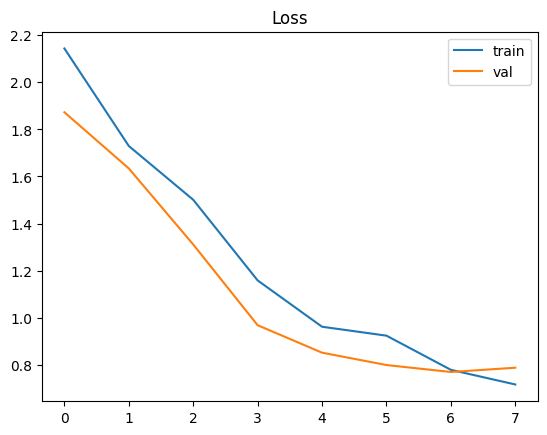

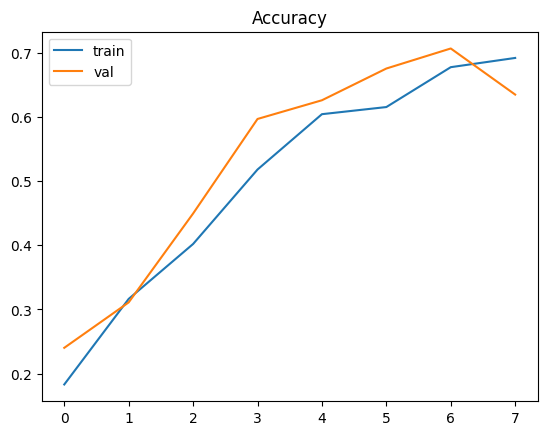

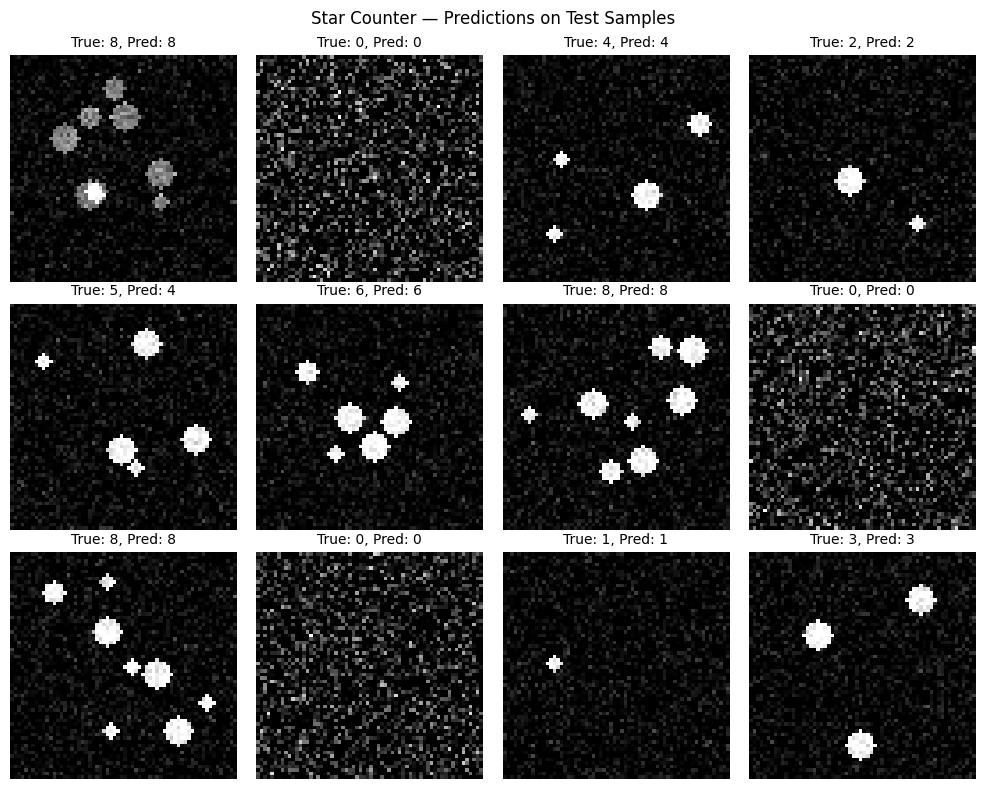

In [2]:
# starcounter_visual.py — End-to-End PyTorch Project with Visualizations
import os, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from PIL import Image

# --- Configs ---
IMG_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 8
BATCH_SIZE = 64
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# --- Synthetic dataset ---
def make_star_image(H, W, k, min_r=2, max_r=4, margin=5, noise_std=0.1):
    img = np.zeros((H, W), dtype=np.float32)
    y = np.arange(H).reshape(-1, 1); x = np.arange(W).reshape(1, -1)
    for _ in range(k):
        r = np.random.randint(min_r, max_r+1)
        cy = np.random.randint(margin+r, H-margin-r)
        cx = np.random.randint(margin+r, W-margin-r)
        mask = (y-cy)**2 + (x-cx)**2 <= r**2
        img[mask] += 1.0
    if img.max() > 0: img /= img.max()
    if noise_std > 0: img += np.random.normal(0, noise_std, size=img.shape).astype(np.float32)
    return np.clip(img, 0, 1)

def generate_dataset(n_samples=1000):
    y = np.random.randint(0, NUM_CLASSES, size=(n_samples,), dtype=np.int64)
    X = np.zeros((n_samples, 1, IMG_SIZE, IMG_SIZE), dtype=np.float32)
    for i, k in enumerate(y): X[i,0] = make_star_image(IMG_SIZE, IMG_SIZE, int(k))
    return torch.from_numpy(X), torch.from_numpy(y)

# --- Model ---
class CountNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8,128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128,NUM_CLASSES)
        )
    def forward(self,x): return self.classifier(self.features(x))

def accuracy(logits, targets):
    return (torch.argmax(logits,1)==targets).float().mean().item()

# --- Training + Visualization ---
def train():
    X_train,y_train=generate_dataset(3000)
    X_val,y_val=generate_dataset(600)
    X_test,y_test=generate_dataset(600)

    train_loader=DataLoader(TensorDataset(X_train,y_train),batch_size=BATCH_SIZE,shuffle=True)
    val_loader=DataLoader(TensorDataset(X_val,y_val),batch_size=BATCH_SIZE)
    test_loader=DataLoader(TensorDataset(X_test,y_test),batch_size=BATCH_SIZE)

    model=CountNet().to(DEVICE)
    opt=torch.optim.Adam(model.parameters(),lr=LR)
    loss_fn=nn.CrossEntropyLoss()

    history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
    for epoch in range(1,EPOCHS+1):
        model.train(); total_loss=total_acc=0; n=0
        for xb,yb in train_loader:
            xb,yb=xb.to(DEVICE),yb.to(DEVICE)
            opt.zero_grad(); out=model(xb)
            loss=loss_fn(out,yb); loss.backward(); opt.step()
            total_loss+=loss.item(); total_acc+=accuracy(out,yb); n+=1
        tr_loss, tr_acc = total_loss/n, total_acc/n

        model.eval(); v_loss=v_acc=0; n=0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb,yb=xb.to(DEVICE),yb.to(DEVICE)
                out=model(xb); v_loss+=loss_fn(out,yb).item(); v_acc+=accuracy(out,yb); n+=1
        v_loss,v_acc=v_loss/n,v_acc/n
        history["train_loss"].append(tr_loss); history["val_loss"].append(v_loss)
        history["train_acc"].append(tr_acc); history["val_acc"].append(v_acc)
        print(f"Epoch {epoch}/{EPOCHS} | Train {tr_loss:.3f}/{tr_acc:.3f} | Val {v_loss:.3f}/{v_acc:.3f}")

    # --- Test ---
    all_preds,all_targets=[],[]
    model.eval()
    with torch.no_grad():
        for xb,yb in test_loader:
            xb=xb.to(DEVICE); out=model(xb)
            all_preds.append(torch.argmax(out,1).cpu()); all_targets.append(yb)
    preds=torch.cat(all_preds); targets=torch.cat(all_targets)
    test_acc=(preds==targets).float().mean().item()
    print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

    # --- Training curves ---
    plt.figure(); plt.plot(history["train_loss"],label="train"); plt.plot(history["val_loss"],label="val")
    plt.title("Loss"); plt.legend(); plt.show()
    plt.figure(); plt.plot(history["train_acc"],label="train"); plt.plot(history["val_acc"],label="val")
    plt.title("Accuracy"); plt.legend(); plt.show()

    # --- Visualize predictions on test samples ---
    n_show=12
    fig, axes = plt.subplots(3,4,figsize=(10,8))
    sample_idx = np.random.choice(len(X_test), n_show, replace=False)
    with torch.no_grad():
        for i,idx in enumerate(sample_idx):
            img=X_test[idx,0].numpy()
            true=int(y_test[idx].item())
            pred=int(model(X_test[idx:idx+1].to(DEVICE)).argmax().item())
            ax=axes[i//4,i%4]
            ax.imshow(img,cmap="gray")
            ax.set_title(f"True: {true}, Pred: {pred}", fontsize=10)
            ax.axis("off")
    plt.suptitle("Star Counter — Predictions on Test Samples")
    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    train()
